In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hydra
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
# Load hydra config
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

In [3]:
experiment_path = Path("../results/explainability_benchmark_corrected/DTEC_DSIL_deterministic_0.5_s0/synthetic_f10_s5000_c4_r0.033_0.033_0.033_v0")

In [4]:
with initialize(version_base=None, config_path=experiment_path.__str__()):
    cfg=compose(config_name="experiment_config.yaml")
    cfg.dataset.dataset_path = "../" + cfg.dataset.dataset_path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import sys
sys.path.append('../src')
from models.dte import DTECategorical
from utils import (check_cuda, get_dataset,
                   low_density_anomalies, select_model, setup_experiment)

2024-12-19 21:15:52.497301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 21:15:52.511364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 21:15:52.515660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 21:15:52.526553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 21:15:53.334710: W tensorflow/comp

In [47]:
import yaml
dataset_dir = Path(cfg.dataset.dataset_path).parent
anomalies_info_path = dataset_dir / 'anomaly_information.yaml'
with open(anomalies_info_path, 'r') as f:
    anomlies_info = yaml.load(f, Loader=yaml.FullLoader)

anomlies_info

{'cluster': {'alpha': 3, 'features': 'all'},
 'global': {'alpha': 1.025, 'features': [1, 6, 2]},
 'local': {'alpha': 1.05, 'features': [0, 6, 4, 8]}}

In [6]:
model_config = cfg.model
model = DTECategorical(
            hidden_size=model_config.model_parameters.hidden_size,
            epochs=model_config.training.epochs,
            batch_size=model_config.training.batch_size,
            lr=model_config.training.learning_rate,
            num_bins=model_config.model_parameters.num_bins,
            T=model_config.model_parameters.T,
            device=device,
        )


In [7]:
data = get_dataset(cfg)
model.load_model(experiment_path / "model.pth", X=data["X_train"])

{'Samples': 5000, 'Features': 10, 'Anomalies': 495, 'Anomalies Ratio(%)': 9.9}


/home/elouan/code/code_repo/notebooks/../src/models/dte.py:426: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [8]:
x = data['X_train']
y = data['y_train']
anomaly_x = x[y >= 1]

In [9]:
anomaly_x.shape

(330, 10)

In [10]:
# TSNE fit on X_train
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(x)


In [34]:
step = 1
t_max = model.T

In [35]:
distances = torch.zeros(anomaly_x.shape[0], anomaly_x.shape[1],len(range(0, t_max,step)))
original_pred = model.predict_score(anomaly_x)
pred_diff = torch.zeros(anomaly_x.shape[0], anomaly_x.shape[1],len(range(0, t_max, step)))
for i in tqdm(range(anomaly_x.shape[-1]), desc="Single features"):
    for j, t in enumerate(range(0, t_max, step)):
        X_noisy = np.copy(anomaly_x)
        X_noisy[:, i] = (
            model.forward_noise(
                torch.tensor(X_noisy[:, i]),
                torch.tensor([t], dtype=torch.long),
            )
            .detach()
            .cpu()
        )
        # Compute euclidean distance
        dist = np.linalg.norm(anomaly_x - X_noisy, axis=1)
        distances[:, i, j] = torch.tensor(dist)
        x_noisy_pred = model.predict_score(X_noisy)
        pred_diff[:, i, j] = torch.tensor(x_noisy_pred - original_pred)


print(distances.shape)
distances = distances.mean(axis=0)
pred_diff = pred_diff.mean(axis=0)

Single features:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([330, 10, 400])


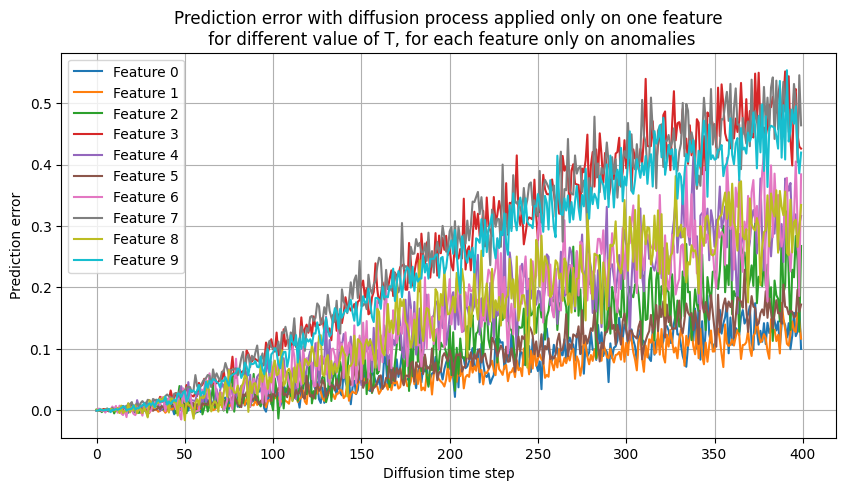

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 5))
#Plot curves for each feature
for i in range(distances.shape[0]):
    # sns.lineplot(x=range(0, model.T, step), y=distances[i, :],  color='r')
    sns.lineplot(x=range(0, t_max, step), y=pred_diff[i, :], label=f"Feature {i}")
plt.xlabel("Diffusion time step")
plt.ylabel("Prediction error")  
plt.title("Prediction error with diffusion process applied only on one feature\n for different value of T, for each feature only on anomalies")
plt.grid()
# Legend red are distances, blue are prediction differences
plt.show()

In [39]:
x = data['X_train']
y = data['y_train']
normal_x = x[y == 0]

In [40]:
step = 1

In [41]:
distances = torch.zeros(normal_x.shape[0], normal_x.shape[1],len(range(0, model.T,step)))
original_pred = model.predict_score(normal_x)
pred_diff = torch.zeros(normal_x.shape[0], normal_x.shape[1],len(range(0, model.T, step)))
for i in tqdm(range(normal_x.shape[-1]), desc="Single features"):
    for j, t in enumerate(range(0, model.T, step)):
        X_noisy = np.copy(normal_x)
        X_noisy[:, i] = (
            model.forward_noise(
                torch.tensor(X_noisy[:, i]),
                torch.tensor([t], dtype=torch.long),
            )
            .detach()
            .cpu()
        )
        # Compute euclidean distance
        dist = np.linalg.norm(normal_x - X_noisy, axis=1)
        distances[:, i, j] = torch.tensor(dist)
        x_noisy_pred = model.predict_score(X_noisy)
        pred_diff[:, i, j] = torch.tensor(x_noisy_pred - original_pred)


print(distances.shape)
distances = distances.mean(axis=0)
pred_diff = pred_diff.mean(axis=0)

Single features:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([4670, 10, 400])


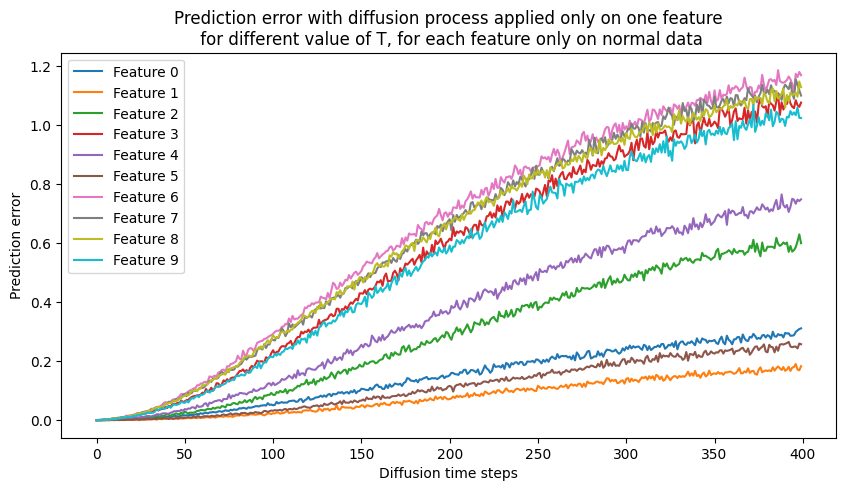

In [44]:
import seaborn as sns

plt.figure(figsize=(10, 5))
#Plot curves for each feature
for i in range(distances.shape[0]):
    # sns.lineplot(x=range(0, model.T, step), y=distances[i, :], color='red', label=f"Feature {i}")
    sns.lineplot(x=range(0, model.T, step), y=pred_diff[i, :], label=f"Feature {i}")
plt.xlabel("Diffusion time steps")
plt.ylabel("Prediction error")  
plt.title("Prediction error with diffusion process applied only on one feature\n for different value of T, for each feature only on normal data")
# Remove legend
plt.legend()
plt.show()

Text(0.5, 1.0, 'Density of the anomaly scores on the whole dataset')

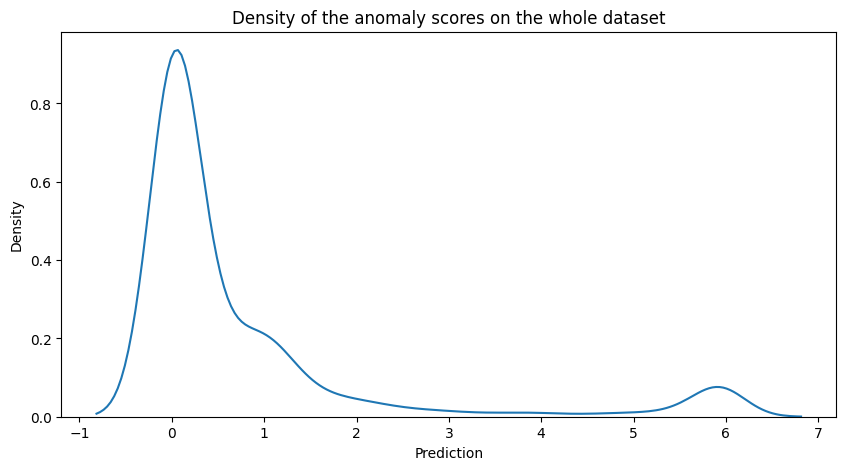

In [18]:
# Pred on the whole dataset
x = data['X_train']

preds = model.predict_score(x)

# Density of the predictions    
plt.figure(figsize=(10, 5))
sns.kdeplot(preds, label="Prediction")
plt.xlabel("Prediction")
plt.title("Density of the anomaly scores on the whole dataset")

In [19]:
# Take an anomalies for which the label is 2
x = data['X_train']
print(x.shape)
x_global = x[data['y_train'] == 6]

x_global.shape

(5000, 10)


(165, 10)

In [20]:
x_global.shape

(165, 10)

In [21]:
step = 5

In [22]:
distances = torch.zeros(x_global.shape[0], x_global.shape[1],len(range(0, model.T,step)))
original_pred = model.predict_score(x_global)
pred_diff = torch.zeros(x_global.shape[0], x_global.shape[1],len(range(0, model.T, step)))
for i in tqdm(range(x_global.shape[-1]), desc="Single features"):
    for j, t in enumerate(range(0, model.T, step)):
        X_noisy = np.copy(x_global)
        X_noisy[:, i] = (
            model.forward_noise(
                torch.tensor(X_noisy[:, i]),
                torch.tensor([t], dtype=torch.long),
            )
            .detach()
            .cpu()
        )
        # Compute euclidean distance
        dist = np.linalg.norm(x_global - X_noisy, axis=1)
        distances[:, i, j] = torch.tensor(dist)
        x_noisy_pred = model.predict_score(X_noisy)
        pred_diff[:, i, j] = torch.tensor(x_noisy_pred - original_pred)

distances = distances.mean(axis=0)
pred_diff = pred_diff.mean(axis=0)


Single features:   0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
pred_diff = pred_diff.squeeze()
distances = distances.squeeze()

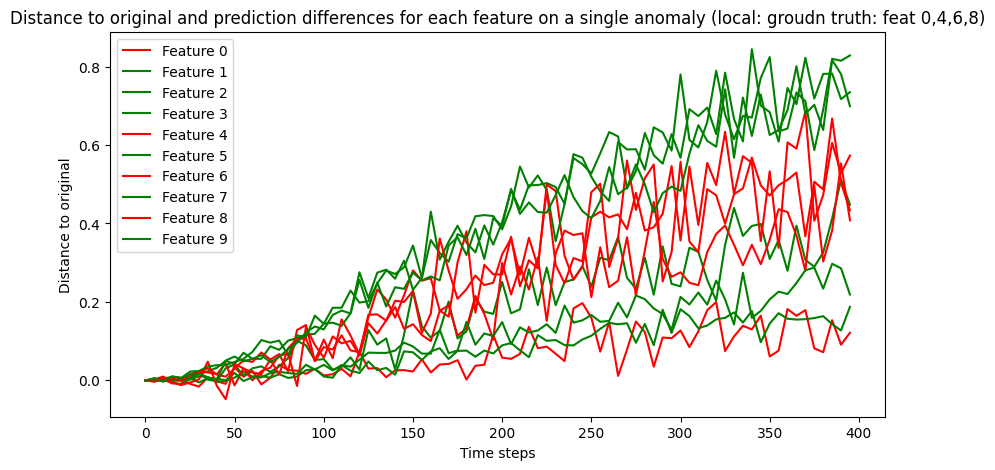

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 5))
#Plot curves for each feature
for i in range(distances.shape[0]):
    # sns.lineplot(x=range(0, model.T, step), y=distances[i, :], color='red', label=f"Feature {i}")
    if i in [0,4,6,8]:
        sns.lineplot(x=range(0, model.T, step), y=pred_diff[i, :], label=f"Feature {i}", color='red')
    else:
            sns.lineplot(x=range(0, model.T, step), y=pred_diff[i, :], label=f"Feature {i}", color='green')
plt.xlabel("Time steps")
plt.ylabel("Distance to original")  
plt.title("Distance to original and prediction differences for each feature on a single anomaly (local: groudn truth: feat 0,4,6,8)")
# Remove legend
plt.legend()
plt.show()

In [25]:
# Explain instance

feature_importance = model.instance_explanation(x_global, np.zeros_like(x_global), "", "")
feature_importance = feature_importance.mean(axis=0)
feature_importance = feature_importance.squeeze()

plt.bar(np.arange(10), feature_importance)
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance for a single anomaly (local: groudn truth: feat 0,3)")
plt.xticks(np.arange(10))

Single features:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Take an anomalies for which the label is 2
x = data['X_train']
x_local = x[data['y_train'] == 6]

x_local.shape

(83, 10)

In [ ]:
distances = torch.zeros(x_local.shape[0], x_local.shape[1],len(range(0, model.T,step)))
original_pred = model.predict_score(x_local)
pred_diff = torch.zeros(x_local.shape[0], x_local.shape[1],len(range(0, model.T, step)))
for i in tqdm(range(x_local.shape[-1]), desc="Single features"):
    for j, t in enumerate(range(0, model.T, step)):
        X_noisy = np.copy(x_local)
        X_noisy[:, i] = (
            model.forward_noise(
                torch.tensor(X_noisy[:, i]),
                torch.tensor([t], dtype=torch.long),
            )
            .detach()
            .cpu()
        )
        # Compute euclidean distance
        dist = np.linalg.norm(x_global - X_noisy, axis=1)
        distances[:, i, j] = torch.tensor(dist)
        x_noisy_pred = model.predict_score(X_noisy)
        pred_diff[:, i, j] = torch.tensor(x_noisy_pred - original_pred)
distances = distances.mean(axis=0)
pred_diff = pred_diff.mean(axis=0)

Single features:   0%|          | 0/10 [00:00<?, ?it/s]

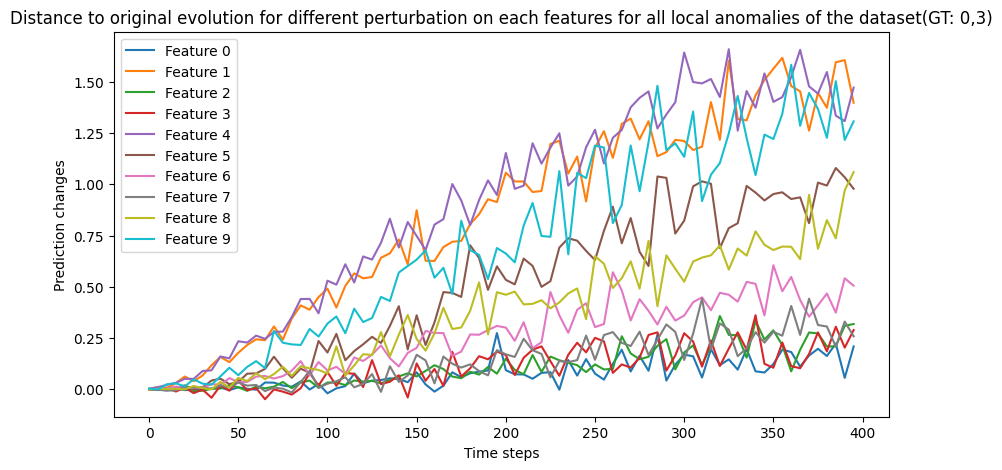

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
#Plot curves for each feature
for i in range(distances.shape[0]):
    # sns.lineplot(x=range(0, model.T, step), y=distances[i, :])
    sns.lineplot(x=range(0, model.T, step), y=pred_diff[i, :], label=f"Feature {i}")
plt.xlabel("Time steps")
plt.ylabel("Prediction changes")  
plt.title("Distance to original evolution for different perturbation on each features for all local anomalies of the dataset(GT: 0,3)")
plt.legend()
# Legend red are distances, blue are prediction differences
plt.show()

In [ ]:
x